## Using a CNN to estimate track parameters

In [1]:
# Standard imports
import sys
print(sys.executable)
# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers
from keras.preprocessing.sequence import pad_sequences


from drawing import draw_event, draw_input_and_pred

/anaconda3/envs/trackml/bin/python


Using TensorFlow backend.


### Configuration

In [2]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 30

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

# Scale track slopes up so that slopes and intercepts receive equal weights in the loss function.
slope_scale = det_width/2

# Number of tracks in each event follows Poisson distribution
mean_tracks = 3
max_tracks = 6

### Functions for toy data generation

In [3]:
def simulate_straight_track(m, b, det_shape):
    """
    Simulate detector data for one straight track.
    Parameters:
        m: track slope parameter
        b: track first-layer intercept parameter (detector entry point)
        det_shape: tuple of detector shape: (depth, width)
    Returns:
        ndarray of binary detector data for one track.
    """
    x = np.zeros(det_shape)
    idx = np.arange(det_shape[0])
    hits = (idx*m + b).astype(int)
    valid = (hits > 0) & (hits < det_shape[1])
    x[idx[valid], hits[valid]] = 1
    return x

# Generator for single-track events
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth*slope_scale # scaled slope
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = []
        
        for i, (b, m) in enumerate(zip(bs, ms)):
            tracks[i,0] = simulate_straight_track(m/slope_scale, b, det_shape)
            targets.append((b,m))
        yield tracks, targets
        
# Generator for multi-track events.
# Each event contains exactly n_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_n_tracks(batch_size=batch_size, det_shape=det_shape, n_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=n_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, n_tracks, 2))
        for n in range(batch_size):
            tracks,targets = next(gen_single)
            batch_events[n,0] = np.clip( sum( tracks ), 0, 1)
            event_targets = np.asarray(targets)
            batch_targets[n] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets
        
# Generator for multi-track events.
# Each event contains up to max_tracks tracks.
# The target track parameters are sorted in increasing order of intercept.
def gen_multi_tracks(batch_size=batch_size, det_shape=det_shape, mean_tracks=mean_tracks):
    gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)
    while True:
        batch_events = np.zeros((batch_size, 1, det_depth, det_width))
        batch_targets = -np.ones((batch_size, max_tracks, 2))
        for n in range(batch_size):
            num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
            # NF FIXME
            num_tracks = max(1, num_tracks)
            tracks,targets = next(gen_single)
            batch_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
            event_targets = np.asarray(targets[:num_tracks])
            
            batch_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
        yield batch_events, batch_targets

### Test the multi-track generator

[[ 18.16588917   8.59550869]
 [ 49.7126792  -19.06961966]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]]


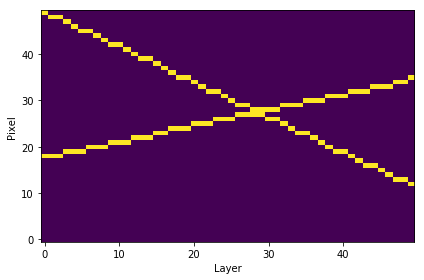

In [5]:
g = gen_multi_tracks()
tracks, targets = next(g)
draw_event(tracks[0,0])
print(targets[0])

### Generate a fixed dataset of multi-track events

In [6]:
epoch_size = 51200
gen_single = gen_tracks(batch_size=max_tracks, det_shape=det_shape)

train_events = np.zeros((epoch_size, 1, det_depth, det_width))
train_targets = -99 * np.ones((epoch_size, max_tracks, 2))
train_weights = np.zeros((epoch_size, max_tracks))
for n in range(epoch_size):
    num_tracks = min( max_tracks, np.random.poisson(mean_tracks) )
    # NF FIXME
    num_tracks = max(1, num_tracks)
    tracks,targets = next(gen_single)
    train_events[n,0] = np.clip( sum( tracks[:num_tracks] ), 0, 1)
    event_targets = np.asarray(targets[:num_tracks])
    train_targets[n,:num_tracks] = event_targets[event_targets[:,0].argsort()] # sort by first column
    train_weights[n,:num_tracks] = np.ones((num_tracks))

[[  2.92073213  20.85346895]
 [ 23.98241281 -10.69998031]
 [ 41.22988567 -10.33449398]
 [ 48.34189249 -17.76373935]
 [-99.         -99.        ]
 [-99.         -99.        ]]
[ 1.  1.  1.  1.  0.  0.]


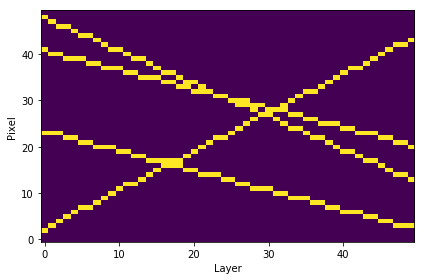

In [11]:
# Check the training data
test_index = np.random.randint(epoch_size)
draw_event(train_events[test_index,0])
print (train_targets[test_index])
print (train_weights[test_index])

### Build and train CNN + LSTM model

In [12]:
# Model
def build_model_1():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1,det_depth, det_width))
    layer = layers.Conv2D(8, (3, 3), padding='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Conv2D(8, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2), data_format="channels_first")(layer)
    layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(mean_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    
    return model

In [13]:
# Train the model
model_1 = build_model_1()
model_1.summary()
train_generator = gen_n_tracks()
# this is gonna take a long time if you don't have GPU, because the generator eats up CPU(generator, step_size, and epochs)
%time model_1.fit_generator(train_generator, epoch_size, 10)
model_2.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=10, validation_split=0.1, sample_weight=train_weights)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 50, 50)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 50, 8)          3608      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 50, 8)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 50, 8)          584       
_________________________________________________________________
activation_2 (Activation)    (None, 1, 50, 8)          0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 25, 4)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 25, 32)         1184      
__________

KeyboardInterrupt: 

NameError: name 'model_2' is not defined

### Visualize model predictions

[[  6.12049798   5.9763082 ]
 [ 13.77351897  12.80043281]
 [ 28.76215041  10.54338944]]
[[  7.76871967   9.86675453]
 [ 13.96037006   9.83374023]
 [ 27.1605587    2.53309822]]


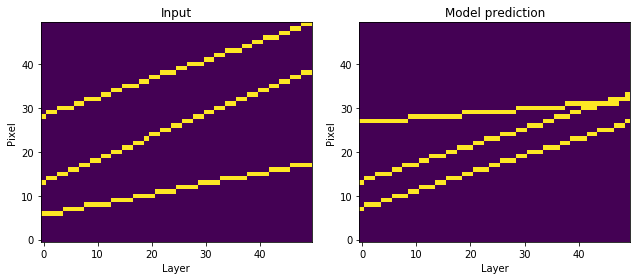

In [14]:
g = gen_n_tracks()
test_data = next(g)
test_event = test_data[0][0]
test_target = test_data[1][0]
test_pred = model_1.predict(np.asarray([test_event]))[0]
print (test_target)
print (test_pred)
pred_event = np.clip(sum([ simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

### Train on events with variable number of tracks

In [15]:
# Model
def build_model_2():
    """Test model.  Consists of several convolutional layers followed by dense layers and an LSTM"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Conv2D(8, (3, 3), padding='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Conv2D(8, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2), data_format="channels_first")(layer)
    layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Conv2D(32, (3, 3), padding='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer) 
    layer = layers.Dense(400)(layer)
    layer = layers.RepeatVector(max_tracks)(layer)
    layer = layers.LSTM(400, return_sequences=True)(layer)
    output_layer = layers.TimeDistributed(layers.Dense(2))(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam', sample_weight_mode="temporal")
    return model

In [16]:
# Train the model
model_2 = build_model_2()
model_2.summary()
model_2.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=10, validation_split=0.1, sample_weight=train_weights)

/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ti...)`
/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 50, 50)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 50, 8)          3608      
_________________________________________________________________
activation_5 (Activation)    (None, 1, 50, 8)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 50, 8)          584       
_________________________________________________________________
activation_6 (Activation)    (None, 1, 50, 8)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 25, 4)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1, 25, 32)         1184      
__________

In [23]:
model_2.fit(train_events, train_targets, batch_size=batch_size, nb_epoch=10, validation_split=0.1, sample_weight=train_weights)

/anaconda3/envs/trackml/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 46080 samples, validate on 5120 samples
Epoch 1/10
46080/46080 [==============================] - 47s 1ms/step - loss: 9.8500 - val_loss: 10.1213
Epoch 2/10
46080/46080 [==============================] - 49s 1ms/step - loss: 9.6523 - val_loss: 10.7010
Epoch 3/10
46080/46080 [==============================] - 49s 1ms/step - loss: 9.5183 - val_loss: 9.9287
Epoch 4/10
46080/46080 [==============================] - 49s 1ms/step - loss: 9.2851 - val_loss: 9.6319
Epoch 5/10
46080/46080 [==============================] - 49s 1ms/step - loss: 9.0918 - val_loss: 9.5965
Epoch 6/10
46080/46080 [==============================] - 50s 1ms/step - loss: 9.0579 - val_loss: 10.0849
Epoch 7/10
46080/46080 [==============================] - 50s 1ms/step - loss: 8.7562 - val_loss: 9.2107
Epoch 8/10
46080/46080 [==============================] - 50s 1ms/step - loss: 8.5795 - val_loss: 9.2028
Epoch 9/10
46080/46080 [==============================] - 50s 1ms/step - loss: 8.3916 - val_loss: 9.3819
Epo

### Visualize prediction

[[  6.87244306  13.66172282]
 [ 13.82059334   1.48163046]
 [ 20.97074307   0.3881765 ]
 [ 23.94479202  -5.43169503]
 [ 30.26090504   3.95646294]
 [ 48.05010309  -1.35179219]]
[[  8.13655853  11.52244854]
 [ 14.19422722   5.02745247]
 [ 19.2810688    0.5855943 ]
 [ 23.22237968  -4.08244562]
 [ 30.07831573   1.32927108]
 [ 44.67248535  -0.51130813]]


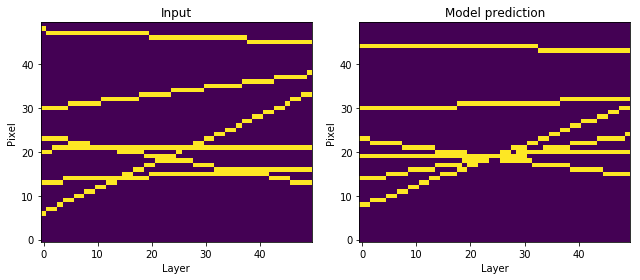

In [27]:
test_index = np.random.randint(epoch_size*0.9,epoch_size)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_target = train_targets[test_index][test_weights]
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
print (test_target)
print (test_pred)
pred_event = np.clip(sum([simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)

46976
[[  9.64588999   7.31099978]
 [  9.75018102  14.76308988]
 [-99.         -99.        ]
 [-99.         -99.        ]
 [-99.         -99.        ]
 [-99.         -99.        ]]
[ True  True False False False False]
[[  9.64588999   7.31099978]
 [  9.75018102  14.76308988]]
[[  7.94410419  13.96577358]
 [ 11.27180672   8.7650013 ]]


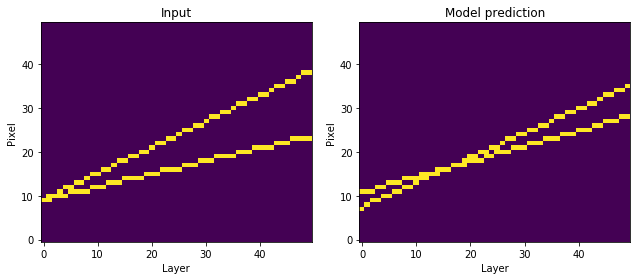

In [37]:
test_index = np.random.randint(epoch_size*0.9,epoch_size)
print(test_index)
test_event = train_events[test_index]
test_weights = train_weights[test_index].astype(np.bool_)
test_target = train_targets[test_index][test_weights]
print(train_targets[test_index])
print(test_weights)
test_pred = model_2.predict(np.asarray([test_event]))[0][test_weights]
print (test_target)
print (test_pred)
pred_event = np.clip(sum([simulate_straight_track(line[1]/slope_scale, line[0], det_shape) for line in test_pred ]), 0, 1)
draw_input_and_pred(test_event[0], pred_event)